## Load DataFrame

In [75]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import os
from constants import TOXICITY_SCORES_PICKLE, PERSPECTIVE_API_LEN_LIMIT, PERSPECTIVE_API_ATTRIBUTES, PERSPECTIVE_API_RESPONSE_DIR, URLS_PICKLE, DATA_DIR

In [4]:
# Load Perspective API responses into dataframe
ATTRIBUTE_COLUMNS = [a.lower() for a in PERSPECTIVE_API_ATTRIBUTES]

def load_api_responses():
    if not TOXICITY_SCORES_PICKLE.exists():
        rows = []

        for toxicity_file in PERSPECTIVE_API_RESPONSE_DIR.iterdir():
            if toxicity_file.suffix != '.json':
                continue            

            # load toxicity score
            toxicity_json = json.load(toxicity_file.open())
            scores = []
            for attribute in PERSPECTIVE_API_ATTRIBUTES:
                try:
                    score = toxicity_json['attributeScores'][attribute]['summaryScore']['value']
                except:
                    score = None
                scores.append(score)

            # split filename
            basename, *exts = toxicity_file.name.split(os.extsep)
            assert exts[0] == 'txt' and exts[-1] == 'json'

            # load text
            chunk_num = int(exts[1].split('-')[1]) if len(exts) == 3 else 0
            text_filename = basename + '.' + exts[0]
            text = (TEXTS_DIR / text_filename).read_text()[PERSPECTIVE_API_LEN_LIMIT * chunk_num: PERSPECTIVE_API_LEN_LIMIT * (chunk_num + 1)]

            rows.append([text_filename, text, chunk_num, *scores])

        df = pd.DataFrame(rows, columns=['filename', 'text', 'chunk_num', *ATTRIBUTE_COLUMNS])

        # Save a pickle for later
        df.to_pickle(TOXICITY_SCORES_PICKLE)
    else:
        df = pd.read_pickle(TOXICITY_SCORES_PICKLE)

    urls = pd.read_pickle(URLS_PICKLE)
    return df.merge(urls, how='left')


df = load_api_responses()

## Basic Analysis

In [16]:
ATTRIBUTE_COLUMNS

['toxicity',
 'severe_toxicity',
 'identity_attack',
 'insult',
 'threat',
 'profanity',
 'sexually_explicit',
 'flirtation']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2064dec450>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad4a1d90>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad429c10>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad57b110>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad59ff50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad5c5f50>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad596050>]],
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fad684890>]],
      dtype=object)

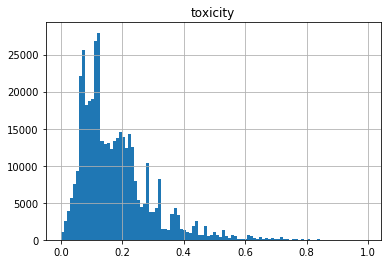

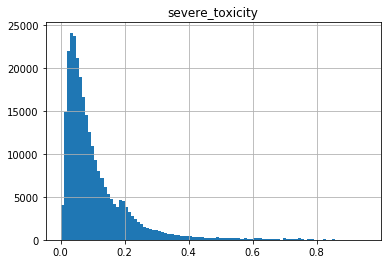

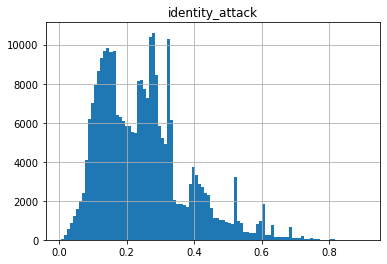

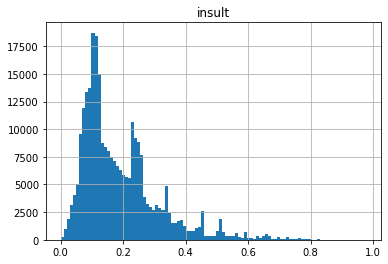

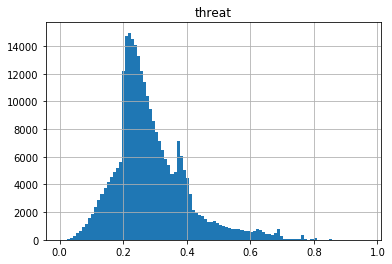

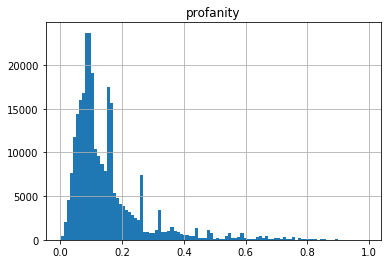

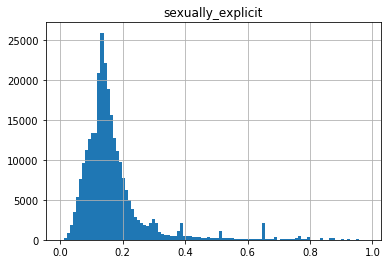

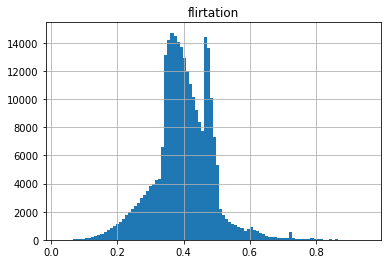

In [23]:
# Histogram of toxicity scores
for a in ATTRIBUTE_COLUMNS:
    display(df.hist(column=a, bins=100))

In [59]:
# Data sorted by toxicity
df.sort_values(by=['identity_attack'], ascending=False).head()

,filename,text,chunk_num,toxicity,severe_toxicity,identity_attack,insult,threat,profanity,sexually_explicit,flirtation,url,domain
303908,0100405-6988e5035a9b17affda427a58b63ac23.txt,"Nigger Music consists of Hip Hop and Rap, Most...",0,0.871854,0.855551,0.906385,0.900344,0.742614,0.859574,0.305453,0.493827,NaN,NaN
184148,0784321-c5d912099845799b9f15f1b676b0067e.txt,Wow! I can't believe you are so hurt! I've see...,0,0.832870,0.779229,0.889870,0.827652,0.687052,0.756411,0.157658,0.466608,https://archive.is/9GMoU,archive.is
220713,0493333-a6f2a2e0e19e3a41e1c302ee74a7f7a4.txt,A black teenager used Facebook Live to reveal ...,0,0.802834,0.854638,0.877267,0.839415,0.530163,0.823162,0.762413,0.645599,NaN,NaN
390772,0005792-55b0464d4abd3a1820d6af774412ffef.txt,With the upcoming debut of Eminem’s Battle Rap...,0,0.871712,0.821408,0.870191,0.901071,0.807092,0.893975,0.366037,0.514029,http://www.hiphopdx.com/index/news/id.28794/ti...,hiphopdx.com
273598,0559481-1c6576e0fc8dff7463ac1678b7b0b321.txt,The bloodthirsty Twitter lynch mob is at it ag...,0,0.790971,0.826633,0.861004,0.817971,0.868598,0.790423,0.396864,0.624161,http://twitchy.com/2013/06/27/ima-kill-me-a-cr...,twitchy.com


In [53]:
# Download list of news sources
!wget https://raw.githubusercontent.com/codelucas/newspaper/master/newspaper/resources/misc/google_sources.txt
!mv google_sources.txt {DATA_DIR}

NEWS_SOURCES = set((DATA_DIR / 'google_sources.txt').read_text().split())

--2019-11-11 20:51:19--  https://raw.githubusercontent.com/codelucas/newspaper/master/newspaper/resources/misc/google_sources.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.52.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.52.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349280 (341K) [text/plain]
Saving to: ‘google_sources.txt’

google_sources.txt  100%[===================>] 341.09K  --.-KB/s    in 0.04s   

2019-11-11 20:51:19 (8.08 MB/s) - ‘google_sources.txt’ saved [349280/349280]



In [71]:
FILTER_SOURCES = NEWS_SOURCES

In [72]:
df2 = df.sort_values(by=['identity_attack'], ascending=False)
df2[~df2['domain'].isin(FILTER_SOURCES)].head(20)

,filename,text,chunk_num,toxicity,severe_toxicity,identity_attack,insult,threat,profanity,sexually_explicit,flirtation,url,domain
303908,0100405-6988e5035a9b17affda427a58b63ac23.txt,"Nigger Music consists of Hip Hop and Rap, Most...",0,0.871854,0.855551,0.906385,0.900344,0.742614,0.859574,0.305453,0.493827,NaN,NaN
184148,0784321-c5d912099845799b9f15f1b676b0067e.txt,Wow! I can't believe you are so hurt! I've see...,0,0.832870,0.779229,0.889870,0.827652,0.687052,0.756411,0.157658,0.466608,https://archive.is/9GMoU,archive.is
220713,0493333-a6f2a2e0e19e3a41e1c302ee74a7f7a4.txt,A black teenager used Facebook Live to reveal ...,0,0.802834,0.854638,0.877267,0.839415,0.530163,0.823162,0.762413,0.645599,NaN,NaN
273598,0559481-1c6576e0fc8dff7463ac1678b7b0b321.txt,The bloodthirsty Twitter lynch mob is at it ag...,0,0.790971,0.826633,0.861004,0.817971,0.868598,0.790423,0.396864,0.624161,http://twitchy.com/2013/06/27/ima-kill-me-a-cr...,twitchy.com
406169,0695228-768468a8fdd4bcfc95a59700dda2397e.txt,the best thing for white men to do? in the int...,0,0.837696,0.821408,0.859465,0.798461,0.807092,0.845175,0.398423,0.540839,http://theanimalnamesofplants.tumblr.com/post/...,tumblr.com
254833,0874201-21cbb5eb488cb1b49b6310a4b5cf2048.txt,If we want our views to become more mainstream...,0,0.767297,0.785906,0.859465,0.807330,0.508405,0.800377,0.454365,0.616028,https://voat.co/v/Niggers/comments/646774,voat.co
58899,0495323-99b9c4b05180d3611bdc1ee1e015a0fd.txt,[Intro: Pusha T & DJ Khaled]\n\nYeah\n\nWe the...,0,0.837852,0.859660,0.851245,0.877252,0.695627,0.893975,0.525562,0.676130,https://genius.com/amp/Dj-khaled-good-man-lyrics,genius.com
373174,0545075-f2153f639772ce4e9fe91de9fe565f39.txt,no one is going to participate in this #whiteo...,0,0.870198,0.854638,0.848002,0.798685,0.396681,0.892332,0.868834,0.756119,http://blackpoeticinjustice.tumblr.com/post/11...,tumblr.com
207978,0851073-915a9afbed72aee8dcd6c92bc8ff8b46.txt,Advisory - the following lyrics contain explic...,0,0.871627,0.886782,0.844047,0.877252,0.765876,0.893975,0.868834,0.755215,http://www.metrolyrics.com/what-the-fuck-lyric...,metrolyrics.com
171789,0147133-8f0b934127b233ac1959666ae00585a1.txt,http://wjla.com/news/local/baltimore-residents...,0,0.769202,0.854638,0.843029,0.824859,0.826278,0.809080,0.652246,0.705501,https://ethnobased.wordpress.com/2017/08/04/ba...,ethnobased.wordpress.com


# TF-IDF

In [ ]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text"])

feature_names = vectorizer.get_feature_names()

In [ ]:
df_idf = pd.DataFrame(vectorizer.idf_, index=feature_names, columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False).head()

In [ ]:
def get_idf_score(filename):
    idx = df[df['filename'] == filename].index
    document_vector = X[idx]
    df_tfidf = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    return df_tfidf.sort_values(by=["tfidf"],ascending=False)

In [ ]:
get_idf_score('0189902-976e23a79df312f42c99556b1efe11e1.txt').head()

In [ ]:
get_idf_score('0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt').head()

# Political Bias

In [80]:
allsides = pd.read_csv(DATA_DIR / 'allsides.csv')

In [83]:
for group, rows in allsides.groupby('bias'):
    display(rows)

,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
3,3162,2.577017,Strongly Agrees,https://www.allsides.com/news-source/allsides-0,allsides,1227,AllSides,4389
4,2051,1.672920,Agrees,https://www.allsides.com/news-source/allsides-...,allsides,1226,AllSides Community,3277
52,318,1.119718,Somewhat Agrees,https://www.allsides.com/news-source/counterpo...,allsides,284,Counterpointing,602
117,67,1.367347,Somewhat Agrees,https://www.allsides.com/news-source/listen-fi...,allsides,49,Listen First Project,116
119,986,0.781300,Somewhat Disagrees,https://www.allsides.com/news-source/living-ro...,allsides,1262,Living Room Conversations,2248
130,30,0.625000,Disagrees,https://www.allsides.com/news-source/mismatcho...,allsides,48,Mismatch.org,78
163,2768,1.725686,Agrees,https://www.allsides.com/news-source/proconorg,allsides,1604,ProCon.org,4372
198,114,0.814286,Somewhat Disagrees,https://www.allsides.com/news-source/suspend-b...,allsides,140,Suspend Belief Podcast,254
220,141,1.453608,Somewhat Agrees,https://www.allsides.com/news-source/flip-side...,allsides,97,The Flip Side,238


,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
2,3371,0.649018,Disagrees,https://www.allsides.com/news-source/al-jazeer...,center,5194,Al Jazeera,8565
10,6338,1.423630,Somewhat Agrees,https://www.allsides.com/news-source/associate...,center,4452,Associated Press,10790
13,1143,0.907143,Somewhat Disagrees,https://www.allsides.com/news-source/axios,center,1260,Axios,2403
14,410,0.843621,Somewhat Disagrees,https://www.allsides.com/news-source/barnstabl...,center,486,Barnstable Patriot,896
15,9449,1.067201,Somewhat Agrees,https://www.allsides.com/news-source/bbc-news-...,center,8854,BBC News,18303
...,...,...,...,...,...,...,...,...
258,103,0.919643,Somewhat Disagrees,https://www.allsides.com/news-source/volante,center,112,Volante,215
261,14,1.272727,Somewhat Agrees,https://www.allsides.com/news-source/wake-poli...,center,11,Wake Up to Politics,25
263,11511,0.669517,Disagrees,https://www.allsides.com/news-source/wall-stre...,center,17193,Wall Street Journal - News,28704
271,109,0.825758,Somewhat Disagrees,https://www.allsides.com/news-source/wfae,center,132,WFAE,241


,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
5,2129,2.940608,Strongly Agrees,https://www.allsides.com/news-source/alternet,left,724,AlterNet,2853
8,735,1.618943,Agrees,https://www.allsides.com/news-source/aquinas-c...,left,454,Aquinas College Saint,1189
9,790,1.325503,Somewhat Agrees,https://www.allsides.com/news-source/arkansas-...,left,596,Arkansas Democrat-Gazette,1386
18,613,1.383747,Somewhat Agrees,https://www.allsides.com/news-source/blue-virg...,left,443,Blue Virginia,1056
19,733,1.562900,Agrees,https://www.allsides.com/news-source/boing-boing,left,469,Boing Boing,1202
30,480,0.960000,Somewhat Disagrees,https://www.allsides.com/news-source/care-2,left,500,Care 2,980
43,6012,3.192777,Absolutely Agrees,https://www.allsides.com/news-source/cnn-edito...,left,1883,CNN - Editorial,7895
55,177,2.809524,Strongly Agrees,https://www.allsides.com/news-source/current-a...,left,63,Current Affairs,240
56,5951,1.513094,Agrees,https://www.allsides.com/news-source/daily-bea...,left,3933,Daily Beast,9884
58,4884,2.640000,Strongly Agrees,https://www.allsides.com/news-source/daily-kos,left,1850,Daily Kos,6734


,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
0,3,1.500000,Somewhat Agrees,https://www.allsides.com/news-source/texas-obs...,left-center,2,The Texas Observer,5
1,11421,1.370246,Somewhat Agrees,https://www.allsides.com/news-source/abc-news-...,left-center,8335,ABC News,19756
11,704,1.058647,Somewhat Agrees,https://www.allsides.com/news-source/atlanta-j...,left-center,665,Atlanta Journal-Constitution,1369
12,629,1.310417,Somewhat Agrees,https://www.allsides.com/news-source/austin-am...,left-center,480,Austin American-Statesman,1109
22,482,0.954455,Somewhat Disagrees,https://www.allsides.com/news-source/bowling-g...,left-center,505,Bowling Green Daily News,987
...,...,...,...,...,...,...,...,...
256,3134,1.560757,Agrees,https://www.allsides.com/news-source/vanity-fair,left-center,2008,Vanity Fair,5142
260,109,0.795620,Somewhat Disagrees,https://www.allsides.com/news-source/vt-digger,left-center,137,VT Digger,246
266,155,1.183206,Somewhat Agrees,https://www.allsides.com/news-source/washingto...,left-center,131,Washington Monthly,286
267,23100,1.624358,Agrees,https://www.allsides.com/news-source/washingto...,left-center,14221,Washington Post,37321


,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
6,5881,2.364696,Strongly Agrees,https://www.allsides.com/news-source/american-...,right,2487,American Spectator,8368
7,1276,1.797183,Agrees,https://www.allsides.com/news-source/american-...,right,710,American Thinker,1986
16,503,1.169767,Somewhat Agrees,https://www.allsides.com/news-source/bearing-d...,right,430,Bearing Drift,933
23,14343,1.895467,Agrees,https://www.allsides.com/news-source/breitbart,right,7567,Breitbart News,21910
31,6008,1.909727,Agrees,https://www.allsides.com/news-source/cbn,right,3146,CBN,9154
39,184,1.115152,Somewhat Agrees,https://www.allsides.com/news-source/city-jour...,right,165,City Journal,349
44,783,1.212074,Somewhat Agrees,https://www.allsides.com/news-source/cns-news,right,646,CNS News,1429
45,722,1.181669,Somewhat Agrees,https://www.allsides.com/news-source/cnsnewscom,right,611,CNSNews.com,1333
47,110,1.037736,Somewhat Agrees,https://www.allsides.com/news-source/commentar...,right,106,Commentary Magazine,216
48,707,2.302932,Strongly Agrees,https://www.allsides.com/news-source/conservat...,right,307,Conservative HQ,1014


,agree,agree_ratio,agreeance_text,allsides_page,bias,disagree,name,total_votes
20,269,1.185022,Somewhat Agrees,https://www.allsides.com/news-source/boston-he...,right-center,227,Boston Herald,496
21,140,1.308411,Somewhat Agrees,https://www.allsides.com/news-source/boston-he...,right-center,107,Boston Herald Editorial,247
61,270,0.745856,Somewhat Disagrees,https://www.allsides.com/news-source/daily-press,right-center,362,Daily Press,632
66,1014,0.623616,Disagrees,https://www.allsides.com/news-source/deseret-news,right-center,1626,Deseret News,2640
68,1806,1.602484,Agrees,https://www.allsides.com/news-source/drudge-re...,right-center,1127,Drudge Report,2933
78,636,1.264414,Somewhat Agrees,https://www.allsides.com/news-source/fiscal-times,right-center,503,Fiscal Times,1139
82,20213,0.677289,Somewhat Disagrees,https://www.allsides.com/news-source/fox-news-...,right-center,29844,Fox News,50057
91,902,1.117720,Somewhat Agrees,https://www.allsides.com/news-source/hotair,right-center,807,HotAir,1709
96,1111,1.107677,Somewhat Agrees,https://www.allsides.com/news-source/independe...,right-center,1003,Independent Journal Review,2114
102,306,0.971429,Somewhat Disagrees,https://www.allsides.com/news-source/intellect...,right-center,315,Intellectual Conservative,621
